In [155]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

## Stable baselines implementation

In [156]:
#TD3, 50000

alg = "SAC"
iteration = 90000
trace1 = "./traces/WIRED_900kbps.json"
trace2 = "./traces/WIRED_35mbps.json"

pickle_path = f"../output/rates_delay_loss_{alg}_{iteration}.pickle"
l_rate = pd.read_pickle(pickle_path)

time_step = 200

In [157]:
l_rate.keys()

dict_keys(['./big_trace/big_trace2.json'])

./big_trace/big_trace2.json
./big_trace/big_trace2.json
./big_trace/big_trace2.json
./big_trace/big_trace2.json
./big_trace/big_trace2.json
./big_trace/big_trace2.json


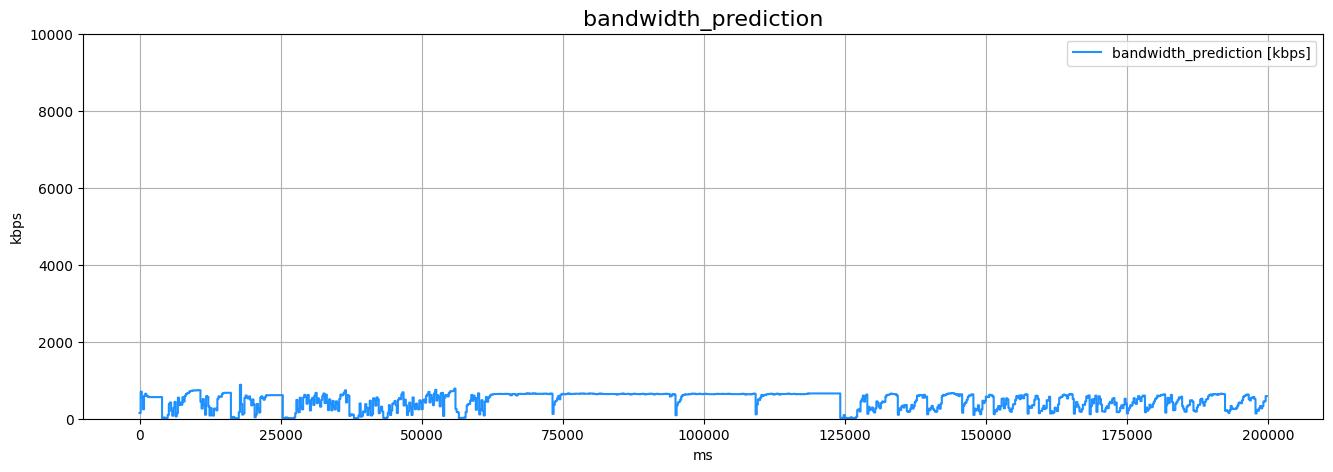

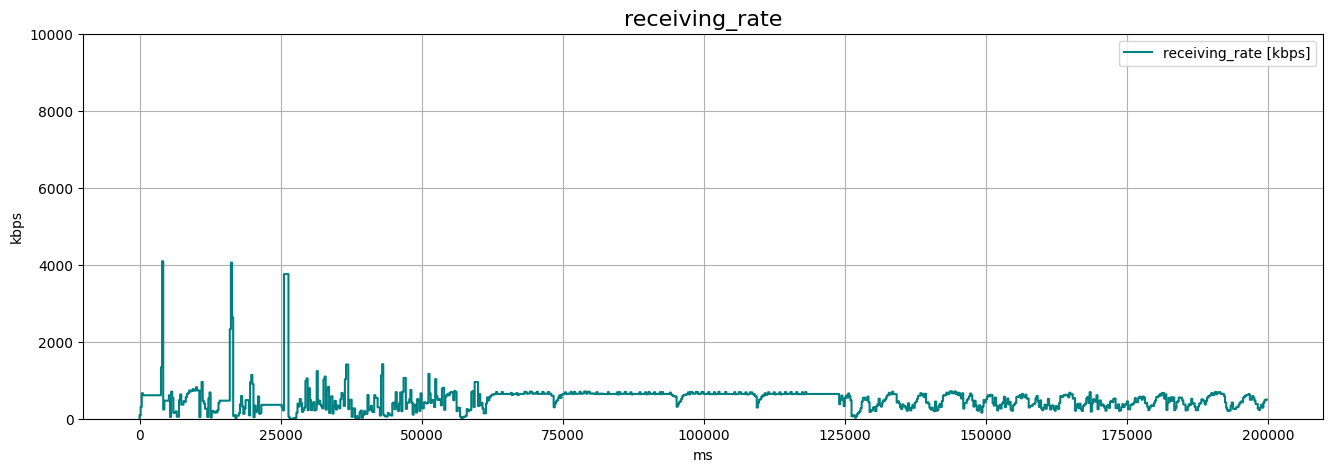

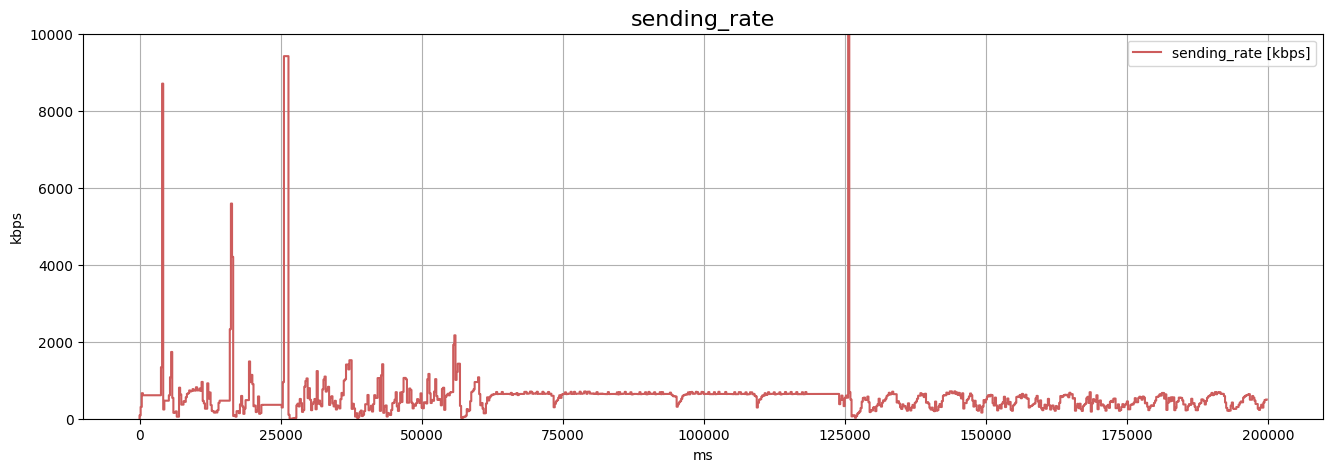

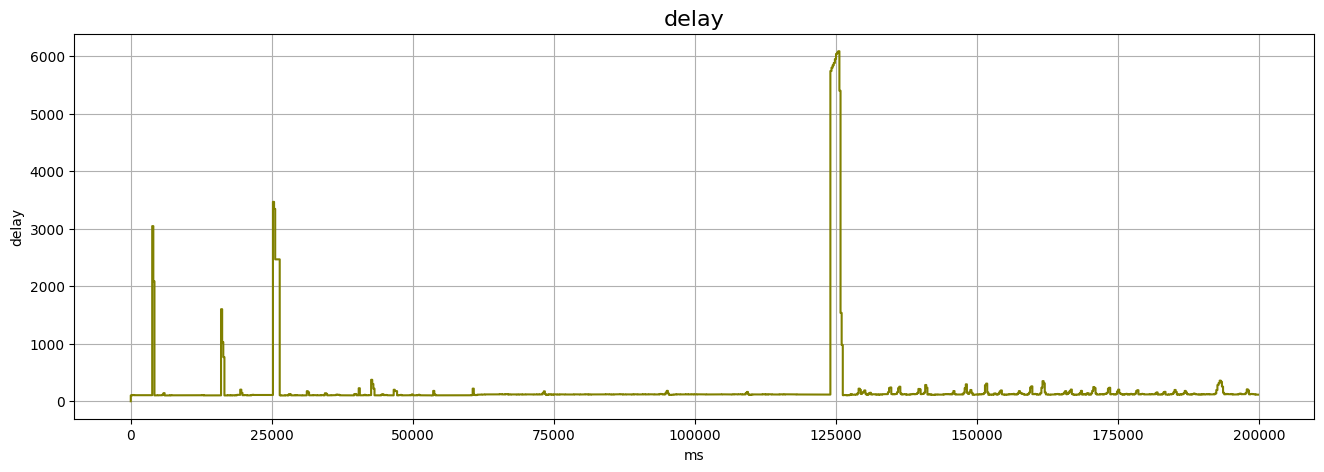

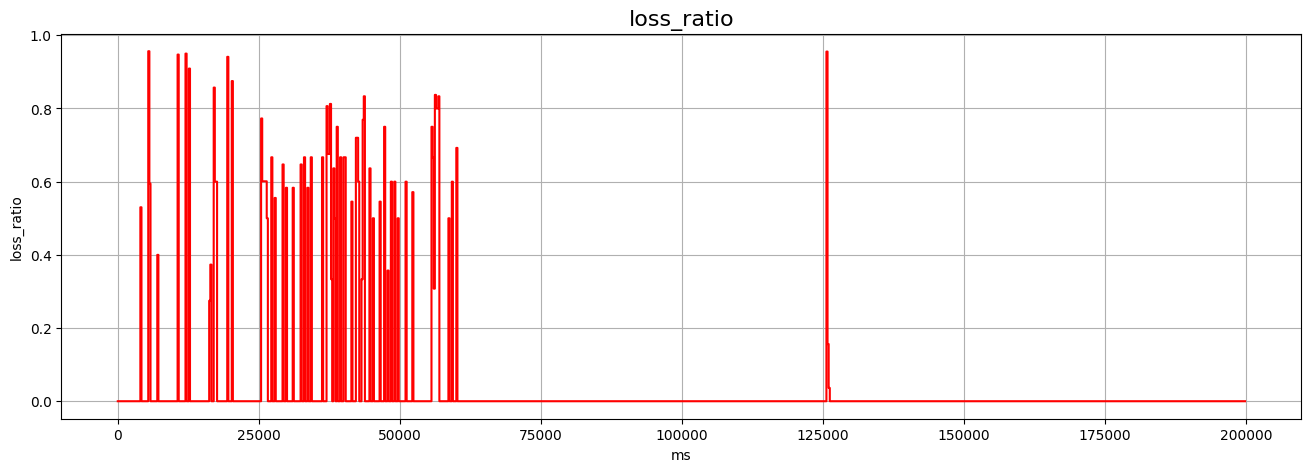

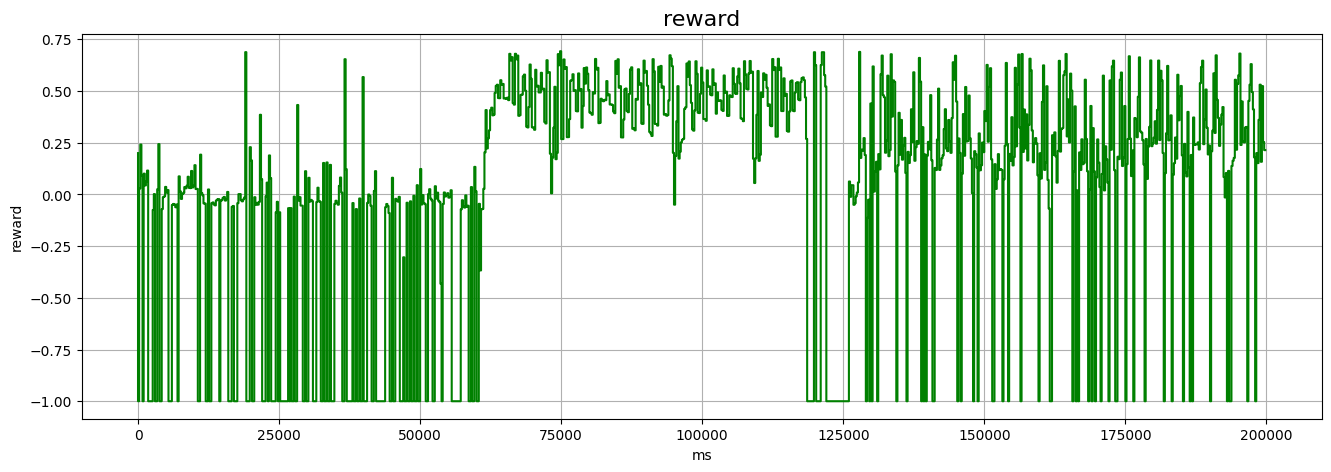

In [160]:
for key in l_rate.keys():
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "red", "green"])

    for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:

        #Define capacity

        trace_name = key
        print(trace_name)
        trace_name = "../" + trace_name.split("/")[1] + "/" + trace_name.split("/")[2]

        with open(trace_name, "r") as f:
            d = json.load(f)

        df = pd.DataFrame(d["uplink"]["trace_pattern"])
        time = [0] + list(df["duration"].cumsum())
        capacities = [df["capacity"].iloc[0]] + list(df["capacity"])    

        df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = t
        df_rate.set_index("time", inplace=True)

        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            plt.figure(figsize=(16,5))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric]/1000, label=f"{metric} [kbps]", color=next(colors))
            # plt.step(time, capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("ms")
            plt.grid()
            plt.ylim((0, 10000))

        else:
            plt.figure(figsize=(16,5))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric], label=f"{metric}", color=next(colors))
            plt.ylabel(metric)
            plt.xlabel("ms")
            plt.grid()

## Calculate scores

##### Be careful of 0 capacity in trace file! - we replace it with a really big number to get U=0, check

In [112]:
def make_bandwidth_series(current_trace, step_time):
    #read bandwidth file and create series
    #index timestamps, values bandwidth
    with open(current_trace, "r") as f:
        d = json.load(f)
    df = pd.DataFrame(d["uplink"]["trace_pattern"])
    time = [0] + list(df["duration"].cumsum())
    capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
    s = pd.Series(index=pd.to_datetime(time, unit="ms"), data=capacities)
    capacities = s.resample(f"{step_time}ms").ffill()
    return capacities

### 1 QoE Utilization - receiving rate

In [127]:
trace_original_name = trace2
print(trace_original_name)

./traces/WIRED_35mbps.json


In [148]:
metric = "receiving_rate"

#Define capacity
trace_name = "../" + trace_original_name.split("/")[1] + "/" + trace_original_name.split("/")[2]

capacities = make_bandwidth_series(trace_name, time_step)

df_rate = pd.DataFrame(l_rate[trace_original_name][metric], columns=[metric])

t = np.arange(len(df_rate))*time_step
df_rate["time"] = pd.to_datetime(t, unit="ms")
df_rate.set_index("time", inplace=True)

receiving_rate_kbps = df_rate["receiving_rate"]/1000
capacities_kbps = capacities.replace(0, 100000000)

U = receiving_rate_kbps / capacities_kbps
U

time
1970-01-01 00:00:00.000    0.000000e+00
1970-01-01 00:00:00.200    8.652000e-07
1970-01-01 00:00:00.400    5.609524e-03
1970-01-01 00:00:00.600    6.057255e-03
1970-01-01 00:00:00.800    3.734154e-03
                               ...     
1970-01-01 00:01:00.400    1.043440e-02
1970-01-01 00:01:00.600    2.127006e-02
1970-01-01 00:01:00.800    2.891077e-02
1970-01-01 00:01:01.000    3.415273e-02
1970-01-01 00:01:01.200    1.308990e-02
Length: 307, dtype: float64

(0.0, 1.0)

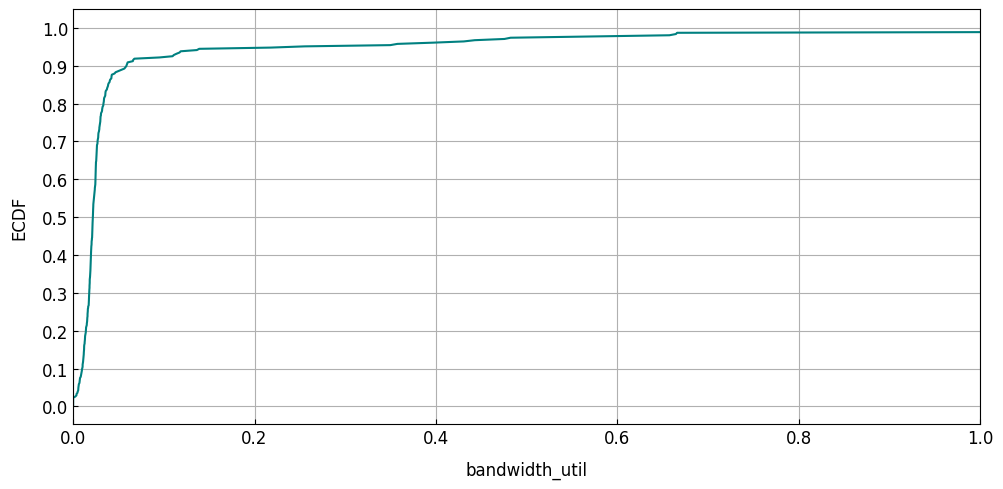

In [154]:
plot_cdf(U, "bandwidth_util")
plt.xlim(0,1)

In [150]:
qoe_rr = 100*U.mean()
qoe_rr

9.944975681470684

### 2 QoE delay

In [134]:
metric = "delay"

df_rate = pd.DataFrame(l_rate[trace_original_name][metric], columns=[metric])

t = np.arange(len(df_rate))*time_step
df_rate["time"] = pd.to_datetime(t, unit="ms")
df_rate.set_index("time", inplace=True)

delay = df_rate["delay"]

<AxesSubplot:>

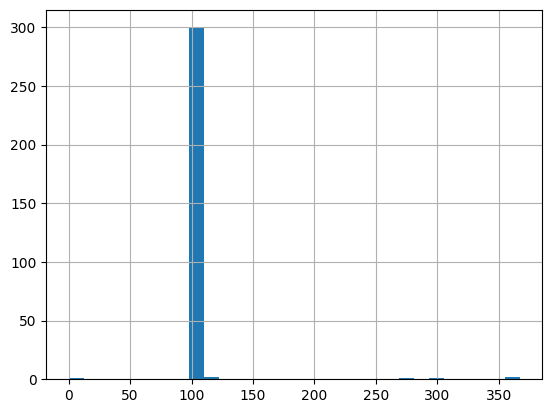

In [135]:
delay.hist(bins=30)

In [136]:
d_max = delay.max()
d_min = delay.min()
d_95 = delay.quantile(0.95)

In [137]:
qoe_delay = 100*(d_max-d_95)/(d_max - d_min)
qoe_delay

71.53950953678473

### 3 QoE losses

In [138]:
metric = "loss_ratio"

df_rate = pd.DataFrame(l_rate[trace_original_name][metric], columns=[metric])

t = np.arange(len(df_rate))*time_step
df_rate["time"] = pd.to_datetime(t, unit="ms")
df_rate.set_index("time", inplace=True)

loss_ratio = df_rate["loss_ratio"]

In [139]:
L = loss_ratio.mean()
L

0.004614549402823018

In [140]:
qoe_losses = 100*(1-L)
qoe_losses

99.53854505971769

### 4 Overall QoE

In [126]:
qoe = 0.2*qoe_rr + 0.2*qoe_delay + 0.3*qoe_losses
qoe

60.34385008212603